# London Tube
Simon Schmetz - Paola Carolina Suarez  
Network Analysis  
Master in Statistics for Data Science  
Universidad Carlos III de Madrid  

Data Source: https://github.com/jaron/railgraph

# Introduction

The "London Underground Network" refers to the metro system of London, UK, encompassing its stations and the connections between them. The network consists of 309 vertices (representing stations), and 370 edges (representing the metro line connections between stations). Notably, multiple metro lines can connect to the same station, resulting in multiple edges. As an undirected network, each edge signifies a bidirectional connection, meaning travel is possible in both directions between stations.



#### Data loading and cleanning

In [42]:
# Load Libraries 
import pandas as pd
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

We begin by loading the Network and extracting the labels of the Stations for later Use.

In [43]:
#Read the Network
G = nx.read_graphml('data/london_tube/tubeDLR.graphml')

# Extract labels from node data
labels = nx.get_node_attributes(G, 'label')

# get node position seperately
pos_geo = {node: (float(data['longitude']), float(data['latitude'])) for node, data in G.nodes(data=True)}


We remove node attributes that were delivered with the network.

In [44]:
# List of attributes to remove
attributes_to_remove = [
    'Betweenness Centrality', 'Closeness Centrality', 'Clustering Coefficient', 
    'Degree', 'Eccentricity', 'Eigenvector Centrality', 'In-Degree', 
    'Number of triangles', 'Out-Degree', 'PageRank', 'b','g',
    'latitude_copy', 'longitude_copy', 'r', 'size', 'x', 'y','displyName'
]

# Remove the attributes from each node
for node, data in G.nodes(data=True):
    for attr in attributes_to_remove:
        data.pop(attr, None)

To further enrich our Network, we take a seperate Dataset that contains average entry and exit values from most of the stations in our Network and add theses to our nodes. To do so, we first remove all stations for which no numbers are available, which as it turns our all correspond to the Docklands Light Railway (DLR) and thus can be knowingly discarded.

In [45]:
### Add Usage Data

usage_data = pd.read_csv('data/london_tube/2017_Entry_Exit.csv')

# Feature Engineering
usage_data['Avg_Exit_Weekend'] = usage_data[['Exit_Saturday', 'Exit_Sunday']].mean(axis=1)
usage_data['Avg_Entry_Weekend'] = usage_data[['Entry_Saturday', 'Entry_Sunday']].mean(axis=1)

usage_data.drop(columns=['Entry_Saturday', 'Entry_Sunday', 'Exit_Saturday', 'Exit_Sunday','Note','Borough','AnnualEntryExit_Mill'], inplace=True)

# Define mapping from non-standard to standard names
station_name_corrections = {
    'Edgware Road (Cir)': 'Edgware Road',
    'Kew Gardens': 'Kew Gardens (London)',
    "Shepherd's Bush (H&C)": "Shepherd's Bush Market",
    "Shepherd's Bush (Cen)": "Shepherd's Bush",
    'Hammersmith (Dis)': 'Hammersmith (Piccadilly and District lines)',
    'Hammersmith (H&C)': 'Hammersmith (Hammersmith & City and Circle lines)',
    "St. John's Wood": "St John's Wood",
    'Bank & Monument': 'Bank-Monument',
    'Totteridge & Whetstone': 'Totteridge and Whetstone',
    'Paddington': 'London Paddington',
    'Richmond': 'Richmond (London)',
    'Heathrow Terminals 123': 'Heathrow Terminals 1, 2, 3',
    'Edgware Road (Bak)': 'Edgware Road (Bakerloo line)',
    'Victoria': 'London Victoria'
}

# Apply corrections to df.Stations
usage_data['Station'] = usage_data['Station'].replace(station_name_corrections)


# Filter nodes in the graph that are available in usage_data
stations_in_usage_data = set(usage_data['Station'])
nodes_to_keep = [node for node, data in G.nodes(data=True) if data.get('label') in stations_in_usage_data]

# Identify stations to be dropped
stations_to_drop = [labels[node] for node, data in G.nodes(data=True) if data.get('label') not in stations_in_usage_data]



# Create a subgraph with only the nodes to keep
G = G.subgraph(nodes_to_keep).copy()

# Add Entry_Week, Exit_Week, Avg_Exit_Weekend, Avg_Entry_Weekend to the attributes of the remaining nodes
for node, data in G.nodes(data=True):
    station_label = data.get('label')
    if station_label in stations_in_usage_data:
        station_data = usage_data[usage_data['Station'] == station_label].iloc[0]
        data['Entry_Week'] = station_data['Entry_Week']
        data['Exit_Week'] = station_data['Exit_Week']
        data['Avg_Exit_Weekend'] = station_data['Avg_Exit_Weekend']
        data['Avg_Entry_Weekend'] = station_data['Avg_Entry_Weekend']

        # Remove edges connected to nodes that are not in the filtered graph
        G.remove_edges_from([(u, v) for u, v in G.edges() if u not in nodes_to_keep or v not in nodes_to_keep])


Then is added the Euclidean Distance between Nodes as a attribute of the arcs using longitude/latitude of the nodes.

In [46]:
# Add "dist" attribute to each edge based on the euclidean distance between nodes in kilometers
for u, v, data in G.edges(data=True):
    lon1, lat1 = pos_geo[u]
    lon2, lat2 = pos_geo[v]
    distance = np.sqrt((lon2 - lon1)**2 + (lat2 - lat1)**2) * 111  # Convert radiants to kilometers
    data['dist'] = distance

This yields us the Network with the following attributes of nodes and edges.

In [47]:
# Attributes

# Nodes
unique_keys = set().union(*(data.keys() for _, data in G.nodes(data=True)))
print("Unique Node Attributes:")
for key in sorted(unique_keys):
    print(f" - {key}")

# Edges
unique_edge_keys = set().union(*(data.keys() for _, _, data in G.edges(data=True)))
print("\nUnique Edge Attributes:")
for key in sorted(unique_edge_keys):
    print(f" - {key}")

Unique Node Attributes:
 - Avg_Entry_Weekend
 - Avg_Exit_Weekend
 - Entry_Week
 - Exit_Week
 - displayName
 - label
 - latitude
 - longitude
 - stationReference

Unique Edge Attributes:
 - Neo4j Relationship Type
 - dist
 - line
 - weight


### Network properties

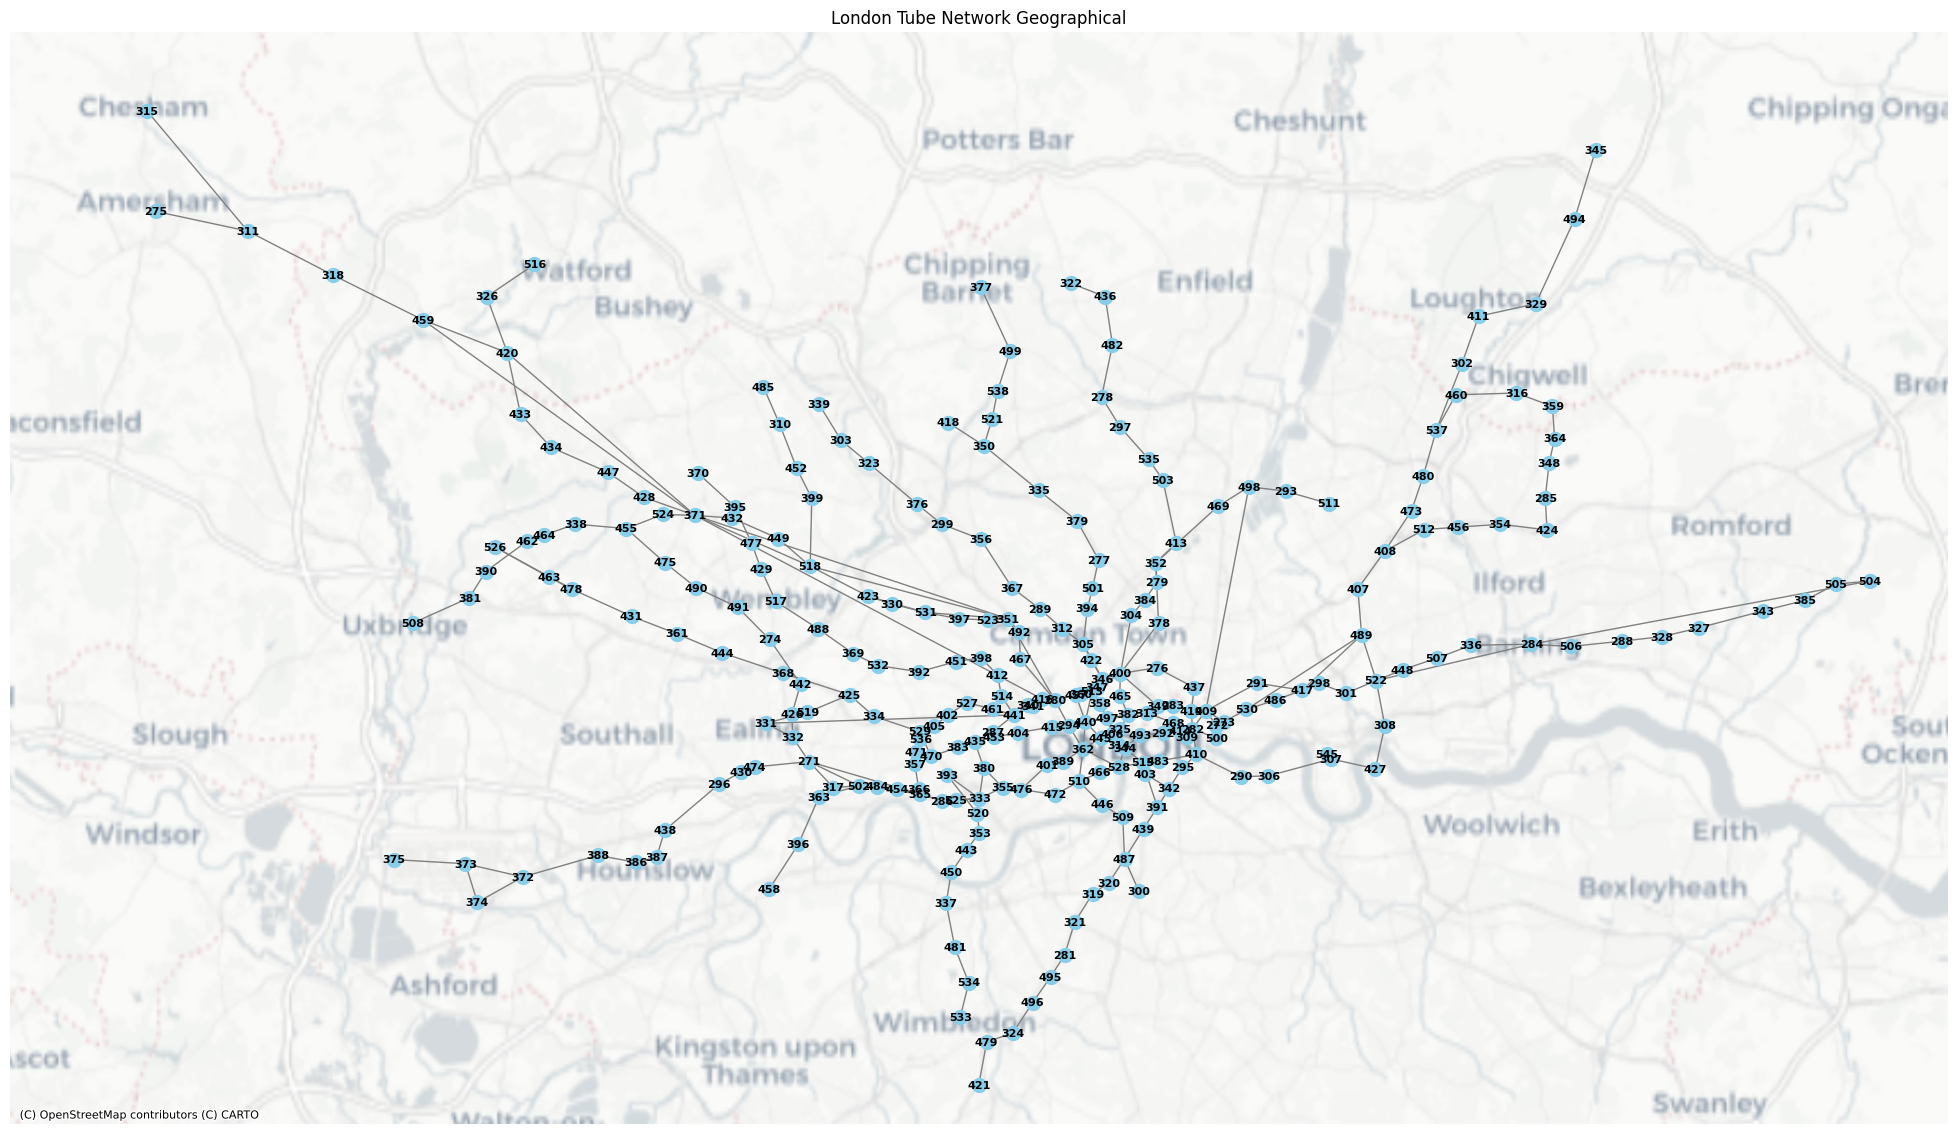

In [48]:
import contextily as ctx
# Create a plot
fig, ax = plt.subplots(figsize=(25, 25))  # More balanced size

# Set the extent to match London's approximate geographical coordinates
ax.set_xlim(-0.68, 0.29)
ax.set_ylim(51.39, 51.73)

# Ensure the correct aspect ratio
ax.set_aspect(1 / np.cos(np.radians((51.4 + 51.73) / 2)))  # Adjust for London's latitude

# Add a basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=10)

# Overlay the London Tube Network
nx.draw(G, pos=pos_geo, with_labels=True, node_size=100, node_color='skyblue', 
        font_size=8, font_weight='bold', edge_color='gray', ax=ax)

# Display the plot
plt.title("London Tube Network Geographical")
plt.show()

The London Underground metro system, after data cleaning, can be represented as an undirected network with 269 nodes (stations) and 324 edges (connections between stations).

In [49]:
# Check if the graph is directed
if isinstance(G, nx.DiGraph):
    print("The graph is directed.")
else:
    print("The graph is undirected.")


#Count nodes
print("Number of Nodes (Order):", G.number_of_nodes())

#Count edges
print("Number of Edges:", len(G.edges(data=True)))


The graph is undirected.
Number of Nodes (Order): 269
Number of Edges: 324


Then, it is checked if there are any isolated vertices (stations) in the network.It is found the isolated vertex '545' in the London Underground network, whichc refers to a station that has no connections to any other stations, making it unreachable within the system. This could have several impacts on the network's functionality. First, passengers would not be able to travel to or from this station via the Underground, potentially disrupting travel routes and forcing reliance on alternate modes of transport. Additionally, the isolation of this station could reduce the overall efficiency of the network, especially if it's located in an area with high commuter traffic. The presence of such isolated nodes also points to potential operational issues or gaps in the network's design, which could affect the system's resilience and flexibility.

In [50]:
# Find isolated vertices
print("Isolated Vertices: ",list(nx.isolates(G)))

Isolated Vertices:  ['545']


Then it is decided to remove this isolated vertex '545', station Canary Wharf, that does not have any connections to any other stations, and serving no additional purpose in the London Underground metro system. By eliminating this node, we aim to improve the overall connectivity and efficiency of the network.

In [51]:
print(labels["545"])

# Remove node '545' from labels and the graph
labels.pop("545", None)
G.remove_node("545")

print("Isolated Vertices: ",list(nx.isolates(G)))


Canary Wharf
Isolated Vertices:  []


In network analysis, specifically in the context of the London Underground metro system, it's important to identify adjacent vertices (stations) and edges (metro lines). This helps to understand the connections between stations and the metro lines serving them. The following code allows us to find these adjacent vertices, revealing the connections between different metro lines at a given station. Additionally, the adjacent edges provide information about possible line changes that a station can offer, indicating where passengers can switch between different metro lines.

In [65]:

# Get the adjacent vertices
chosen_vertex = '487'

adjacent_vertices = list(G.neighbors(chosen_vertex))
print(f"Adjacent vertices of vertex {chosen_vertex}: {adjacent_vertices}")

# Print the labels of the adjacent vertices
adjacent_labels = [labels[vertex] for vertex in adjacent_vertices]
print(f"Adjacent vertices of vertex {labels[chosen_vertex]}: {adjacent_labels}")

Adjacent vertices of vertex 487: ['300', '320', '439', '509']
Adjacent vertices of vertex Stockwell: ['Brixton', 'Clapham North', 'Oval', 'Vauxhall']


In [66]:
# Get the adjacent edges (edges that involve the chosen vertex)
adjacent_edges = G.edges(chosen_vertex)
print(f"Adjacent edges of vertex {chosen_vertex}: {adjacent_edges}")

# Print the details of the adjacent edges, including the metro line (edge attribute)
for edge in adjacent_edges:
    # Assuming the edge attribute 'line' stores the metro line's name
    line_name = G[edge[0]][edge[1]].get('line', 'Unknown Line')  # Default to 'Unknown Line' if not available
    print(f"Edge: {edge} (Connecting {labels[edge[0]]} and {labels[edge[1]]}) - Metro Line: {line_name}")

Adjacent edges of vertex 487: [('487', '300'), ('487', '320'), ('487', '439'), ('487', '509')]
Edge: ('487', '300') (Connecting Stockwell and Brixton) - Metro Line: Victoria_line
Edge: ('487', '320') (Connecting Stockwell and Clapham North) - Metro Line: Northern_line
Edge: ('487', '439') (Connecting Stockwell and Oval) - Metro Line: Northern_line
Edge: ('487', '509') (Connecting Stockwell and Vauxhall) - Metro Line: Victoria_line


The presence of self-loops in the network was examined, and it was determined that the system does not contain any self-loops. This finding is consistent with the design of most metro systems, where a station typically does not have a direct connection to itself via a metro line. Self-loops are generally avoided in urban transit networks for practical reasons, as they would not contribute to effective transportation or improve connectivity.

In [68]:
# Check for self-loops by iterating through the edges
self_loops = [edge for edge in G.edges() if edge[0] == edge[1]]

# If there are any self-loops, print them
if self_loops:
    print(f"The graph has {len(self_loops)} self-loop(s):")
    for loop in self_loops:
        print(loop)
else:
    print("The graph does not have any self-loops.")



The graph does not have any self-loops.


Similarly, it was determined that the network does not contain any multi-edges, which means there are no multiple metro lines connecting the same pair of stations. This is consistent with the design principles of the metro system, where each pair of stations typically has a unique connection served by a single metro line. Having multiple lines between the same two stations is not a common practice, as it can lead to inefficiencies in the network design and complicate operations.

In [69]:
# Check if the graph allows multi-edges (MultiGraph or MultiDiGraph)
if isinstance(G, nx.MultiGraph) or isinstance(G, nx.MultiDiGraph):
    # Iterate over the edges and check for multi-edges
    multi_edges = [edge for edge in G.edges()]
    
    if multi_edges:
        print(f"The graph has multi-edges between the following nodes:")
        for edge in multi_edges:
            print(edge)
    else:
        print("The graph does not have any multi-edges.")
else:
    print("The graph is not a MultiGraph or MultiDiGraph, so multi-edges are not allowed.")


The graph is not a MultiGraph or MultiDiGraph, so multi-edges are not allowed.


#### Degree distribution without weights

The average degree is calculated to be 2.42, which aligns with expectations. As most stations in the metro network are typically connected by a single line, with each station having two adjacent connections: one to the previous station and one to the next. Such a structure is common in metro systems, where the majority of stations are part of a linear sequence of stops

In [72]:
# Calculate the average degree of the graph
average_degree = sum(dict(G.degree()).values()) / len(G.nodes())

print(f"Average degree of the network: {average_degree:.2f}")

Average degree of the network: 2.42


The top 5 nodes with the highest degrees in the network are Harrow-on-the-Hill, Baker Street, Bank-Monument, King's Cross St. Pancras, and Earl's court. Harrow-on-the-Hill stands out with the highest degree of 8, indicating it has the most connections in the network. The other two stations—Baker Street and King's Cross St. Pancras have a degree of 7, showing they are all well-connected with a similar number of edges. Following the other two reamingn stations Bank-monument and Earl's Court have a degree of 6, in general, these stations are central hubs in the network, with varying but significant levels of connectivity. 
These stations are all above the average degree of the network, which is 2.42. Their higher degrees suggest they are significantly more connected than the average station, reflecting their importance in facilitating movement and providing multiple transport links.
Some initial assumptions about their locations and roles in London transportation help provide context, a more detailed analysis would involve evaluating commuter traffic, station facilities, and transport links to further understand their importance within the network.

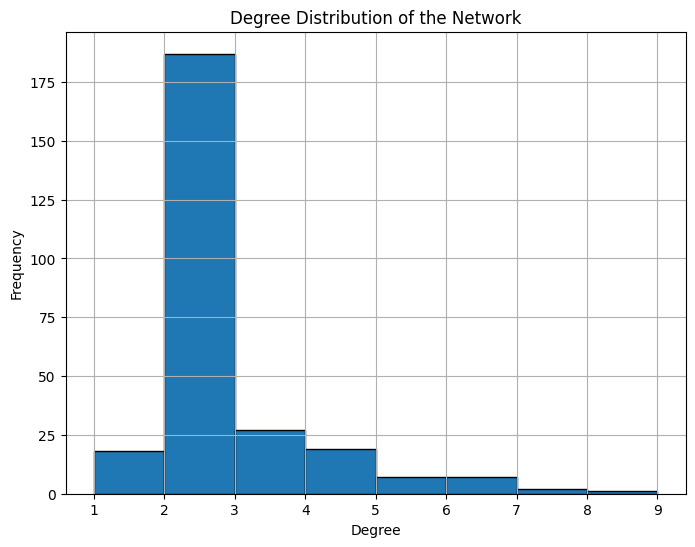


Top 5 nodes with the highest degrees:
Node: 371, Label: Harrow-on-the-Hill, Degree: 8
Node: 280, Label: Baker Street, Degree: 7
Node: 400, Label: King's Cross St. Pancras, Degree: 7
Node: 282, Label: Bank-Monument, Degree: 6
Node: 333, Label: Earl's Court, Degree: 6


In [70]:
# Degree of each node in the graph
degrees = dict(G.degree())  # {node: degree}

# Degree distribution (histogram)
degree_sequence = [degree for node, degree in degrees.items()]

# Plot the degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence) + 2), edgecolor='black')
plt.title('Degree Distribution of the Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find the top 5 nodes with the highest degrees
sorted_nodes_by_degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 nodes with their degrees and labels
print("\nTop 5 nodes with the highest degrees:")
for node, degree in sorted_nodes_by_degree:
    label = G.nodes[node].get('label', 'No Label')
    print(f"Node: {node}, Label: {label}, Degree: {degree}")

#### Degree distribution with weights

The network's degree distribution reveals an average weighted degree of 1.77, indicating that, on average, each station has a relatively modest number of strong connections when considering the inverse of the distance as the weight. Notably, the top 5 stations with the highest weighted degrees, which are Bank-Monument (7.79), Leicester Square (7.18), Embankment (6.36), Charing Cross (5.92), and Waterloo (5.77), are all located in central and highly trafficked areas of the metro system. These stations exhibit significantly higher connectivity strength, suggesting they serve as major hubs where multiple metro lines converge. Their elevated weighted degrees reflect their crucial roles in the network, as they facilitate efficient transfers and high passenger flow. In the metro system is expected that the central stations are designed to handle high volumes of passengers and connections across various lines.

Average weighted degree: 1.77
Top 5 stations with highest weighted degrees:
Station: Bank-Monument (ID: 282), Weighted Degree: 7.79
Station: Leicester Square (ID: 406), Weighted Degree: 7.18
Station: Embankment (ID: 344), Weighted Degree: 6.36
Station: Charing Cross (ID: 314), Weighted Degree: 5.92
Station: Waterloo (ID: 515), Weighted Degree: 5.77


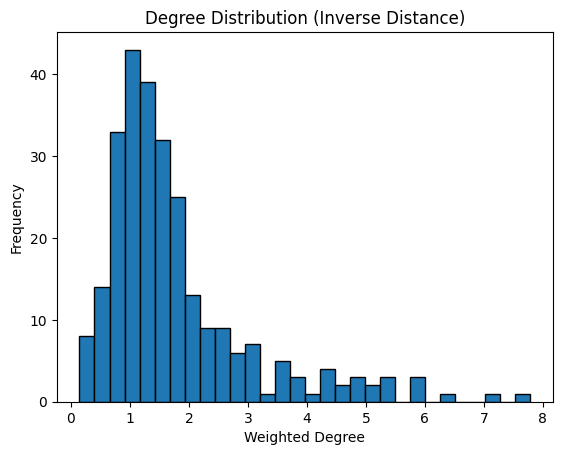

In [77]:
# Step 1: Calculate the weighted degree for each node (using inverse of the distance as weight)
def weighted_degree(graph, labels):
    weighted_degrees = {}
    for node in graph.nodes:
        weighted_degree = 0
        for neighbor in graph.neighbors(node):
            # Get the distance (weight) of the edge (inverse of distance as weight)
            weight = graph[node][neighbor].get('dist', 1)  # Default to 1 if no 'dist' attribute
            weighted_degree += 1 / weight  # Inverse of the distance as strength
        weighted_degrees[node] = weighted_degree
    return weighted_degrees

# Calculate the weighted degree of each station
weighted_degrees = weighted_degree(G, labels)

# Step 2: Calculate the average degree
average_degree = sum(weighted_degrees.values()) / len(weighted_degrees)
print(f"Average weighted degree: {average_degree:.2f}")

# Step 3: Identify the top 5 stations based on the weighted degree
top_5_stations = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

# Display the top 5 stations and their weighted degrees along with station names
print("Top 5 stations with highest weighted degrees:")
for node, degree in top_5_stations:
    station_name = labels.get(node, "Unknown Station")  # Get the station name using the label dictionary
    print(f"Station: {station_name} (ID: {node}), Weighted Degree: {degree:.2f}")

#Plotting the degree distribution (using the inverse distance)
# Get all weighted degrees for plotting
all_degrees = list(weighted_degrees.values())

# Plot the degree distribution
plt.hist(all_degrees, bins=30, edgecolor='black')
plt.title("Degree Distribution (Inverse Distance)")
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")
plt.show()


#### Number of components of the network

As mentioned before, the network is undirected, therefore the number of components in the London Undergroung metro system network reveals that there is only one connected component, indicating that all stations are part of a single, cohesive network. This suggests that the metro system is designed to ensure complete connectivity, with no isolated or disconnected stations. This is ensuring that every station can be reached from any other station, either directly or via transfer.

The fact that there is a single connected component also reflects the network's design efficiency, and confirms that the network is a weakly connected graph, you can travel between any two vertices by following some set of edges. This means that commuters can travel seamlessly between any two points within the system without encountering unreachable stations.
This networks helps in the flexibility of route planning, including multiple tranfer points in more central lines to be able to reach any part of the city that has a metro line.

Additionally, it will enfasises the importance of central lines that can have more traffic, and can serve as critical nodes in maintaining overall network cohesion.

In [ ]:
#Find the connected components
connected_components = list(nx.connected_components(G))

#Calculate the number of connected components
num_components = len(connected_components)

print(f"Number of connected components: {num_components}")
print("Connected components:", connected_components)

Number of connected components: 1
Connected components: [{'362', '420', '453', '483', '530', '421', '351', '306', '320', '476', '284', '275', '456', '470', '304', '444', '406', '501', '405', '330', '416', '519', '512', '294', '474', '372', '409', '488', '411', '419', '429', '387', '459', '443', '467', '388', '462', '337', '413', '273', '489', '298', '380', '278', '510', '538', '365', '285', '509', '430', '451', '271', '398', '449', '407', '331', '274', '425', '531', '432', '511', '460', '498', '326', '359', '389', '463', '473', '529', '478', '323', '497', '408', '535', '342', '321', '537', '302', '300', '494', '426', '418', '457', '513', '397', '400', '486', '518', '465', '349', '288', '433', '360', '363', '338', '310', '487', '279', '484', '479', '327', '291', '528', '516', '527', '447', '297', '504', '350', '357', '378', '455', '493', '282', '381', '481', '440', '525', '491', '468', '437', '366', '276', '377', '386', '329', '346', '373', '316', '311', '272', '452', '347', '280', '303

The following code provides both the sequence of station names along the shortest route and the total distance of travel between the two specified stations, making it useful for analyzing travel routes in the London Undergroung metro system network.

The code calculates the total distance (sum of the weights) of the shortest path using Dijkstra's algorithm, which reflects the total travel distance between the two stations. If no path exists between the nodes or if a node is not found in the graph, appropriate error messages are displayed.   

In [87]:
initial_vertex = '421'
final_vertex = '496'

try:
    path = nx.dijkstra_path(G, source= initial_vertex, target= final_vertex, weight='dist')
    print(f"The shortest path from {initial_vertex} to {final_vertex} is: {path}")

    path_station_names = [G.nodes[node].get('label', 'No Label') for node in path]
    print(f"The shortest path from {initial_vertex} to {final_vertex} (with station names) is: {path_station_names}")

    # Optional: If you want to know the distance (total weight) of the path
    path_distance = nx.dijkstra_path_length(G, source= initial_vertex, target=final_vertex, weight='dist')
    print(f"The total distance (weight) of the path is: {path_distance} km")

except nx.NetworkXNoPath:
    print("No path exists between node 1 and node 10.")
except nx.NodeNotFound as e:
    print(f"Error: {e}")

The shortest path from 421 to 496 is: ['421', '479', '324', '496']
The shortest path from 421 to 496 (with station names) is: ['Morden', 'South Wimbledon', 'Colliers Wood', 'Tooting Broadway']
The total distance (weight) of the path is: 4.549386061111416 km


#### Diameter without weigths

In [90]:
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print(f"The diameter of the connected graph is: {diameter}")
else:
    print("The graph is disconnected.")

The diameter of the connected graph is: 35


Using the Adjecency Matrix, we can calculate the mean giving us an average 0.009 Arcs per nodes^2, showing that overall there is very low connectivity in the network.

In [ ]:
# Generate the adjacency matrix
adj_matrix = nx.adjacency_matrix(G)
adj_matrix_dense = adj_matrix.todense()

# Calculate the mean
mean_adj_matrix = np.mean(adj_matrix_dense)
print(f"Mean of the adjacency matrix: {mean_adj_matrix}")

Mean of the adjacency matrix: 0.009022053909556694


This assumption about the majority of stations having two arcs is validated by the empirical distribution of the degrees, showing degrees = 2 being by far the most common one. Beyond that, there are end/start stations of lines with degree = 1 and hubs that connect more than one line and correspondingly have more than two edges.



## Attribute Analysis

A histogram can be plotted to show the distribution of the distances and the mean distance between stations. It has to be remembered as the distance is a linear approximation (e.g. euclidean distance) and the effective distances that are traveled between stations are slightly higher.

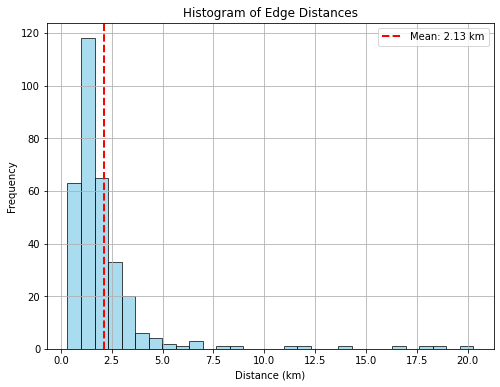

In [291]:
# Plot the histogram
distances = [data['dist'] for _, _, data in G.edges(data=True) if 'dist' in data]
mean_distance = np.mean(distances)

plt.figure(figsize=(8, 6))
plt.hist(distances, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(mean_distance, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f} km')
plt.title('Histogram of Edge Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


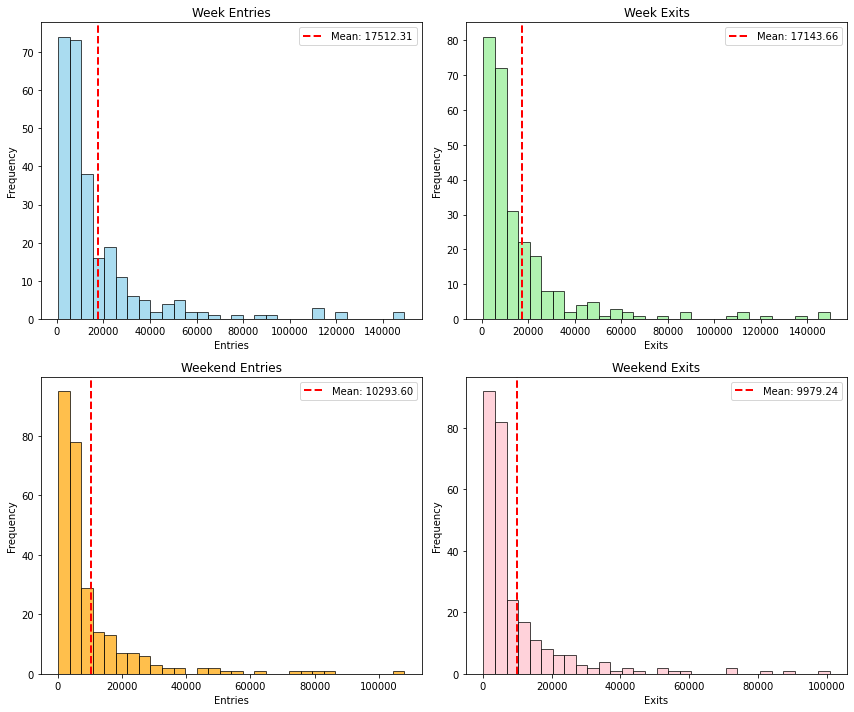

In [295]:
# Extract data for histograms directly from the graph
entry_week = [data['Entry_Week'] for _, data in G.nodes(data=True) if 'Entry_Week' in data]
exit_week = [data['Exit_Week'] for _, data in G.nodes(data=True) if 'Exit_Week' in data]
avg_entry_weekend = [data['Avg_Entry_Weekend'] for _, data in G.nodes(data=True) if 'Avg_Entry_Weekend' in data]
avg_exit_weekend = [data['Avg_Exit_Weekend'] for _, data in G.nodes(data=True) if 'Avg_Exit_Weekend' in data]

# Calculate means
mean_entry_week = np.mean(entry_week)
mean_exit_week = np.mean(exit_week)
mean_avg_entry_weekend = np.mean(avg_entry_weekend)
mean_avg_exit_weekend = np.mean(avg_exit_weekend)

# Create a 4x4 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms with mean lines
axes[0, 0].hist(entry_week, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(mean_entry_week, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_entry_week:.2f}')
axes[0, 0].set_title('Week Entries')
axes[0, 0].set_xlabel('Entries')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(exit_week, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(mean_exit_week, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_exit_week:.2f}')
axes[0, 1].set_title('Week Exits')
axes[0, 1].set_xlabel('Exits')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 0].hist(avg_entry_weekend, bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(mean_avg_entry_weekend, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_avg_entry_weekend:.2f}')
axes[1, 0].set_title('Weekend Entries')
axes[1, 0].set_xlabel('Entries')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(avg_exit_weekend, bins=30, color='pink', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(mean_avg_exit_weekend, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_avg_exit_weekend:.2f}')
axes[1, 1].set_title('Weekend Exits')
axes[1, 1].set_xlabel('Exits')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

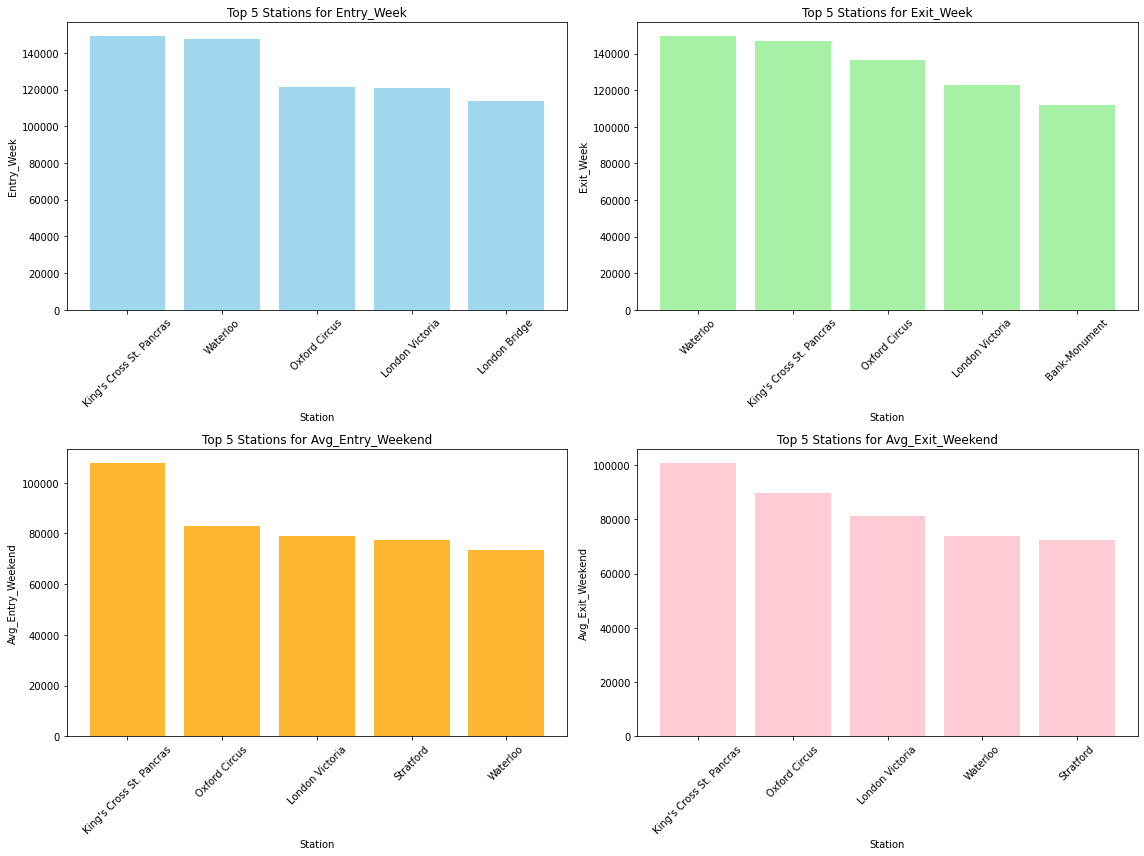

In [299]:
# Define the categories to analyze and their corresponding colors
categories = ['Entry_Week', 'Exit_Week', 'Avg_Entry_Weekend', 'Avg_Exit_Weekend']
colors = ['skyblue', 'lightgreen', 'orange', 'pink']

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot bar diagrams for the top 5 most used stations in each category
for i, category in enumerate(categories):
    row, col = divmod(i, 2)
    top_stations = usage_data.nlargest(5, category)[['Station', category]]
    
    # Create a bar plot in the corresponding subplot
    axes[row, col].bar(top_stations['Station'], top_stations[category], color=colors[i], alpha=0.8)
    axes[row, col].set_title(f"Top 5 Stations for {category}")
    axes[row, col].set_xlabel("Station")
    axes[row, col].set_ylabel(category)
    axes[row, col].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

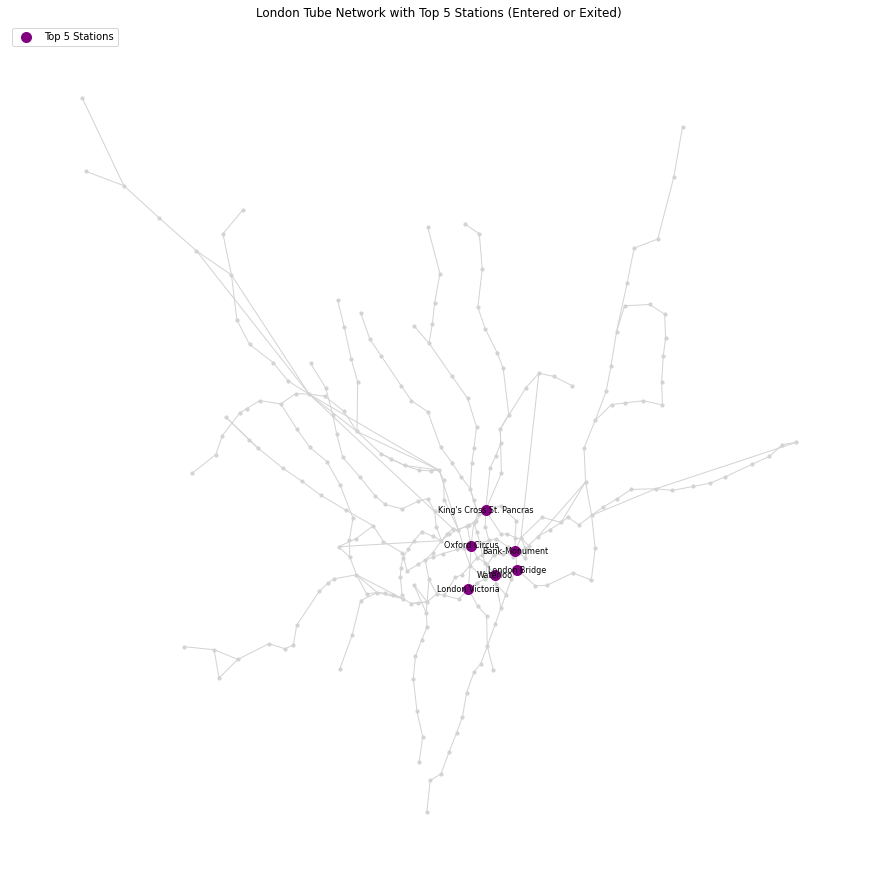

In [312]:
# Identify the top 5 most exited and most entered stations
top_5_exited = usage_data.nlargest(5, 'Exit_Week')[['Station', 'Exit_Week']]
top_5_entered = usage_data.nlargest(5, 'Entry_Week')[['Station', 'Entry_Week']]

# Combine the top 5 exited and entered stations into a single set
top_5_combined_stations = set(top_5_exited['Station']).union(set(top_5_entered['Station']))

# Get the node IDs for these stations
top_5_combined_nodes = [node for node, label in labels.items() if label in top_5_combined_stations]

# Plot the network
plt.figure(figsize=(12, 12))

# Draw the entire network
nx.draw(G, pos=pos_geo, with_labels=False, node_size=10, node_color='lightgray', edge_color='lightgray')

# Highlight the combined top 5 stations
nx.draw_networkx_nodes(G, pos=pos_geo, nodelist=top_5_combined_nodes, node_color='purple', node_size=100, label='Top 5 Stations')

# Add labels for the highlighted stations
nx.draw_networkx_labels(G, pos=pos_geo, labels={node: labels[node] for node in top_5_combined_nodes}, font_size=8)

# Add legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
plt.title("London Tube Network with Top 5 Stations (Entered or Exited)")
plt.show()


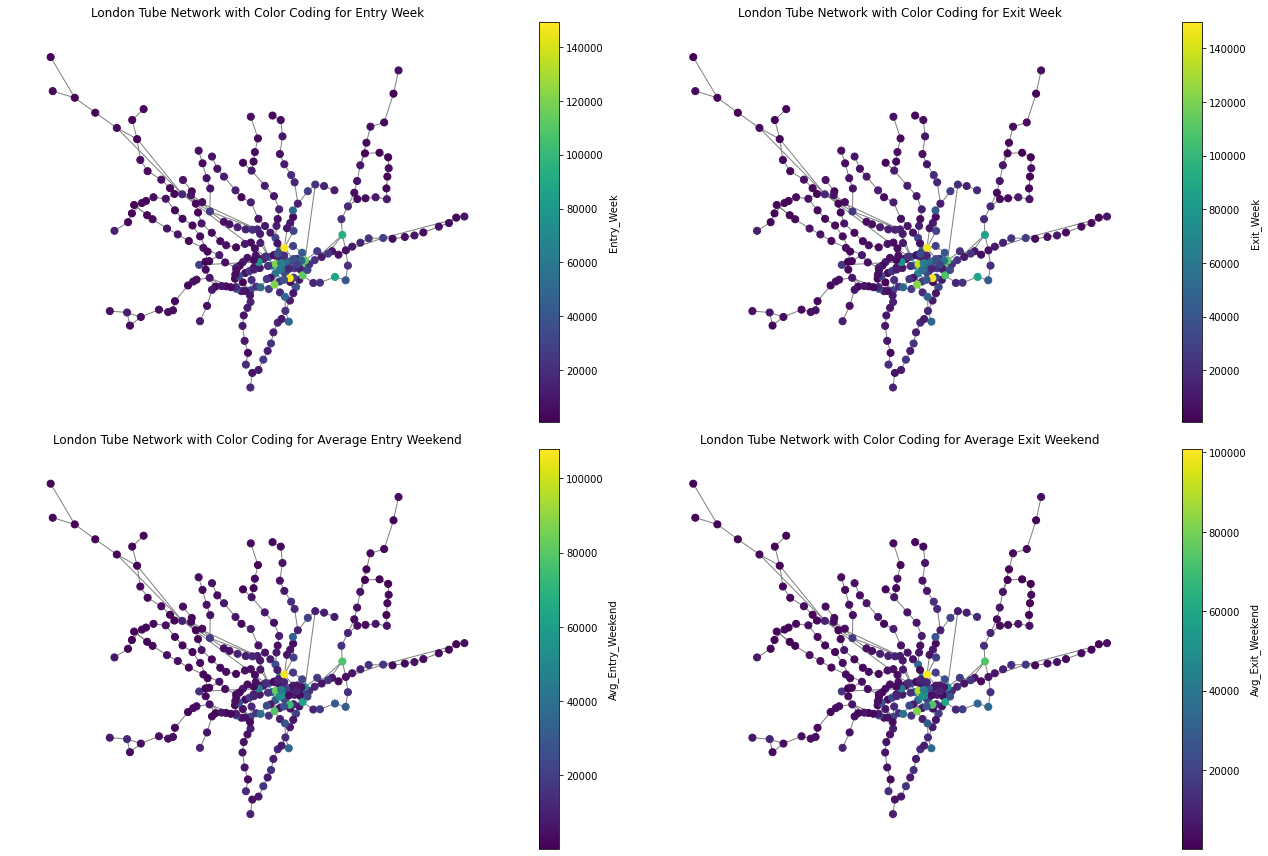

In [335]:
# Define the categories to visualize and their corresponding titles
categories = ['Entry_Week', 'Exit_Week', 'Avg_Entry_Weekend', 'Avg_Exit_Weekend']
titles = ['Entry Week', 'Exit Week', 'Average Entry Weekend', 'Average Exit Weekend']

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Iterate over the categories and plot each one
for i, (category, title) in enumerate(zip(categories, titles)):
    # Extract values for the current category
    values = [data[category] for _, data in G.nodes(data=True) if category in data]
    
    # Normalize the values for the colormap
    norm = plt.Normalize(min(values), max(values))
    cmap = plt.cm.viridis
    
    # Create a color map for the nodes
    node_colors = [cmap(norm(data[category])) if category in data else (0.5, 0.5, 0.5, 1) for _, data in G.nodes(data=True)]
    
    # Plot the network on the corresponding subplot
    ax = axes[i // 2, i % 2]
    nx.draw(
        G, 
        pos=pos_geo, 
        with_labels=False, 
        node_size=50, 
        node_color=node_colors, 
        edge_color='gray',
        ax=ax
    )
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(category)
    
    # Set the title for the subplot
    ax.set_title(f"London Tube Network with Color Coding for {title}")

# Adjust layout
plt.tight_layout()
plt.show()

## Subgraphs


Components (11 Tube Lines + other Lines): 

- Bakerloo
- Central
- Circle
- District
- Hammersmith & City
- Jubilee
- Metropolitan
- Northern
- Piccadilly
- Victoria
- Waterloo & City
- +Light Rail, Regional Lines etc


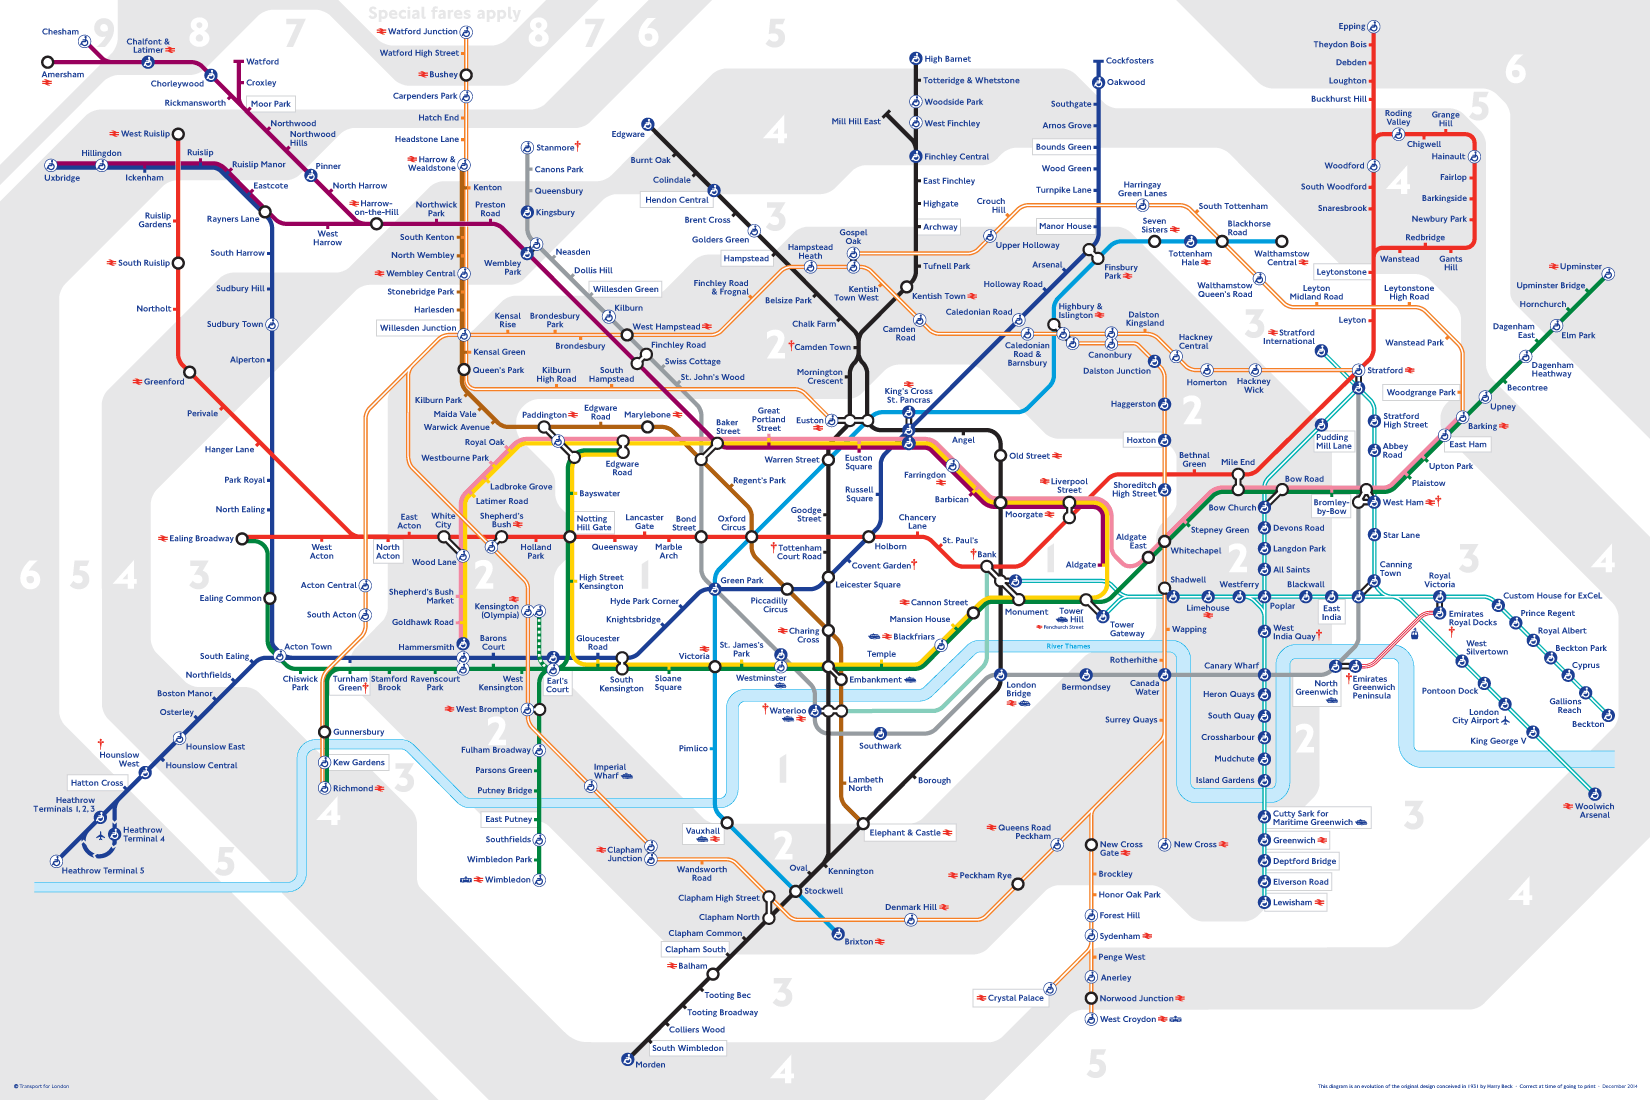

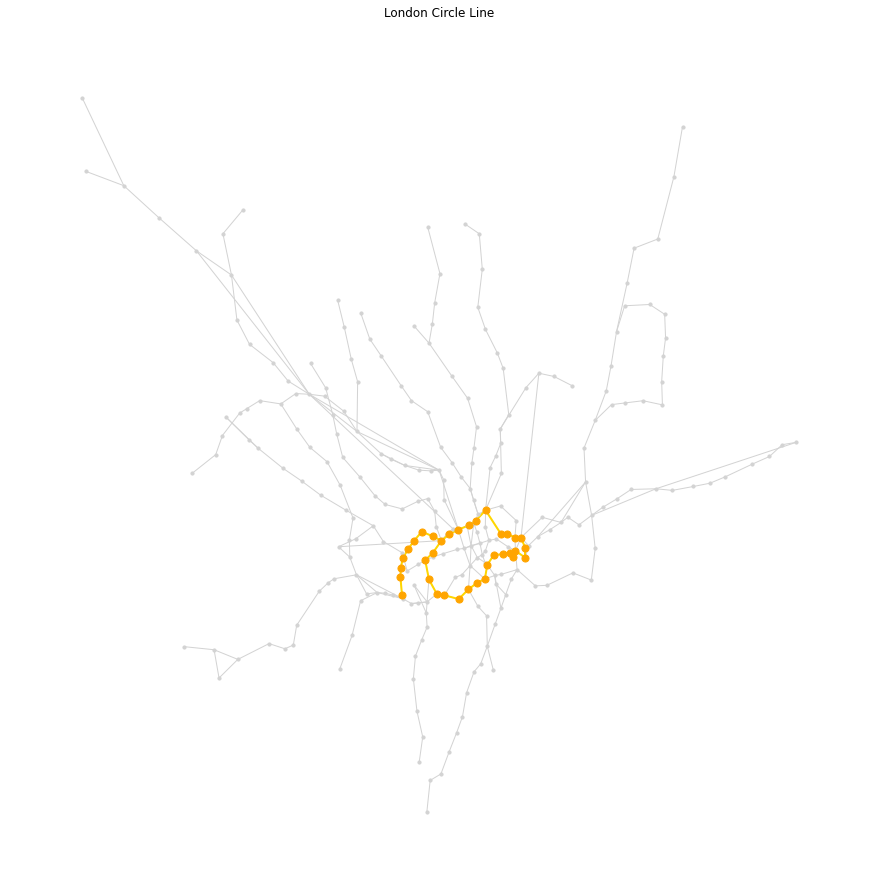

In [322]:
### Circle Line

circle_line_stations = [
    "Hammersmith (Hammersmith & City and Circle lines)",
    "Goldhawk Road",
    "Shepherd's Bush Market",
    "Wood Lane",
    "Latimer Road",
    "Ladbroke Grove",
    "Westbourne Park",
    "Royal Oak",
    "London Paddington",
    "Edgware Road",
    "Baker Street",
    "Great Portland Street",
    "Euston Square",
    "King's Cross St. Pancras",
    "Farringdon",
    "Barbican",
    "Moorgate",
    "Liverpool Street",
    "Aldgate",
    "Tower Hill",
    "Bank-Monument",
    "Cannon Street",
    "Mansion House",
    "Blackfriars",
    "Temple",
    "Embankment",
    "Westminster",
    "St. James's Park",
    "London Victoria",
    "Sloane Square",
    "South Kensington",
    "Gloucester Road",
    "High Street Kensington",
    "Notting Hill Gate",
    "Bayswater"
]


# Get station edges and nodes
circle_line_station_ids = [node for node, name in labels.items() if name in circle_line_stations]
circle_line_edges = [(u, v) for u, v in G.edges() if u in circle_line_station_ids and v in circle_line_station_ids]
circle_line_edges = [edge for edge in circle_line_edges if edge not in [('282', '409'), ('282', '419')]] # remove two incorrect edges
circle_line_nodes = set(circle_line_station_ids)

# Plot
plt.figure(figsize=(12, 12))

nx.draw(G, pos = pos_geo, with_labels=False, node_size=10, node_color='lightgray', edge_color='lightgray')
nx.draw_networkx_edges(G, pos= pos_geo, edgelist=circle_line_edges, edge_color='gold', width=2)
nx.draw_networkx_nodes(G, pos = pos_geo, nodelist=circle_line_nodes, node_color='orange', node_size=50)
nx.draw_networkx_labels(G, pos, labels={node: labels[node] for node in circle_line_nodes}, font_size=8)

plt.title("London Circle Line")
plt.show()


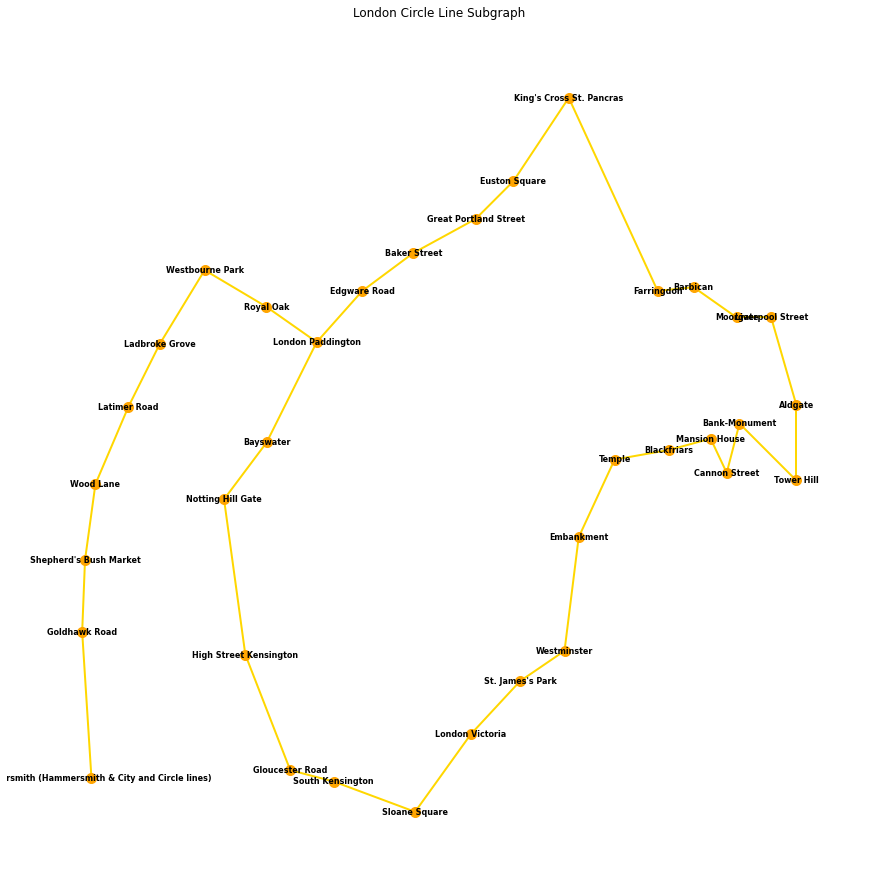

In [323]:
# Extract the subgraph of the Circle Line
circle_line_subgraph = G.subgraph(circle_line_nodes)

# Plot the Circle Line subgraph
plt.figure(figsize=(12, 12))

nx.draw(circle_line_subgraph, pos=pos_geo, with_labels=True, labels={node: labels[node] for node in circle_line_nodes},
    edgelist=circle_line_edges, node_size=100, node_color='orange', font_size=8, font_weight='bold', edge_color='gold', width=2)

plt.title("London Circle Line Subgraph")
plt.show()